# Writing to a File

## Overview

### Questions

* How can I write thermodynamic and other quantities to a file?
* How can I access that data?

### Objectives

* Show how to add all **thermodynamic properties** to a Logger.
* Demonstrate **GSD** as a logging back end.
* Explain how to read logged quantities from a **GSD** file.
* Describe how **namespaces** appear in the names of the logged quantities.

## Boilerplate code

In [1]:
import hoomd
import gsd.hoomd
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

## Binary file formats

In the previous section, you displayed a small number of loggable quantities to standard out.
This is useful for monitoring simulations from the command line, but it quickly becomes untenable when you need to log dozens of scalar and vector quantities for use in later analysis.
Binary file formats are capable of handling these cases with smaller files that are faster to read and write.
In this section, you will log thermodynamic quantities to a **GSD** file.
**GSD** files normally include particle trajectory information, but in this case you will write no particles to the file so that you can save the log quantities with a small period.

If you would like to monitor recent data from the command line, you could write a script that opens the GSD file and displays the quantities you are interested in to stdout.

## Define the Simulation

This tutorial executes the Lennard-Jones particle simulation from the previous tutorial. 
See *Introduction to Molecular Dyamics* for a complete description of this code.

In [2]:
gpu = hoomd.device.GPU()
sim = hoomd.Simulation(device=gpu)
sim.create_state_from_gsd(filename='../01-Introducing-Molecular-Dynamics/random.gsd')

integrator = hoomd.md.Integrator(dt=0.005)
cell = hoomd.md.nlist.Cell()
lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[('A', 'A')] = dict(epsilon=1, sigma=1)
lj.r_cut[('A', 'A')] = 2.5
integrator.forces.append(lj)
nvt = hoomd.md.methods.NVT(kT=1.5, filter=hoomd.filter.All(), tau=1.0)
integrator.methods.append(nvt)
sim.operations.integrator = integrator
sim.run(0)

## Logging thermodynamic quantities

The **ThermodynamicQuantities** class computes a variety of **thermodynamic properties** in MD simulations.
These are all loggable.

In [3]:
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All())
sim.operations.computes.append(thermodynamic_properties)
thermodynamic_properties.loggables

{'state': 'state',
 'kinetic_temperature': 'scalar',
 'pressure': 'scalar',
 'pressure_tensor': 'sequence',
 'kinetic_energy': 'scalar',
 'translational_kinetic_energy': 'scalar',
 'rotational_kinetic_energy': 'scalar',
 'potential_energy': 'scalar',
 'degrees_of_freedom': 'scalar',
 'translational_degrees_of_freedom': 'scalar',
 'rotational_degrees_of_freedom': 'scalar',
 'num_particles': 'scalar'}

To log all of these quantities, call `Logger.add` and omit the `quantities` argument:

In [4]:
logger = hoomd.logging.Logger()
logger.add(thermodynamic_properties)

[('md', 'compute', 'ThermodynamicQuantities', 'state'),
 ('md', 'compute', 'ThermodynamicQuantities', 'kinetic_temperature'),
 ('md', 'compute', 'ThermodynamicQuantities', 'pressure'),
 ('md', 'compute', 'ThermodynamicQuantities', 'pressure_tensor'),
 ('md', 'compute', 'ThermodynamicQuantities', 'kinetic_energy'),
 ('md', 'compute', 'ThermodynamicQuantities', 'translational_kinetic_energy'),
 ('md', 'compute', 'ThermodynamicQuantities', 'rotational_kinetic_energy'),
 ('md', 'compute', 'ThermodynamicQuantities', 'potential_energy'),
 ('md', 'compute', 'ThermodynamicQuantities', 'degrees_of_freedom'),
 ('md',
  'compute',
  'ThermodynamicQuantities',
  'translational_degrees_of_freedom'),
 ('md', 'compute', 'ThermodynamicQuantities', 'rotational_degrees_of_freedom'),
 ('md', 'compute', 'ThermodynamicQuantities', 'num_particles')]

Let's also log the quantities from **Simulation**.

In [5]:
logger.add(sim)

[('Simulation', 'timestep'),
 ('Simulation', 'tps'),
 ('Simulation', 'walltime'),
 ('Simulation', 'final_timestep')]

## Writing log quantities to a GSD file

In addition to the trajectory of the simulation state, GSD files can also store array data provided by **Logger**.
Use the `Null` filter to select no particles so that you can log thermodynamic properties at a high rate and keep the file size small.


In [6]:
gsd_writer = hoomd.write.GSD(filename='trajectory.gsd',
                             trigger=hoomd.trigger.Periodic(1000),
                             mode='wb',
                             filter=hoomd.filter.Null())
sim.operations.writers.append(gsd_writer)

Assign the logger to include the logged quanties in the GSD file:

In [7]:
gsd_writer.log = logger

Run the simulation:

In [8]:
sim.run(200000)

## Reading logged data from a GSD file

Use the `gsd` package to open the file:

In [9]:
traj = gsd.hoomd.open('trajectory.gsd', 'rb')

Each frame in the trajectory has a `log` dictionary that maps quantity names to values.
Inspect this dictionary in the first frame:

In [10]:
traj[0].log

{'md/compute/ThermodynamicQuantities/kinetic_temperature': array([1.53168856]),
 'md/compute/ThermodynamicQuantities/pressure': array([2.49808465]),
 'md/compute/ThermodynamicQuantities/pressure_tensor': array([ 2.41876366,  0.1068456 , -0.11846927,  2.76485433, -0.14537865,
         2.31063596]),
 'md/compute/ThermodynamicQuantities/kinetic_energy': array([1146.46888968]),
 'md/compute/ThermodynamicQuantities/translational_kinetic_energy': array([1146.46888968]),
 'md/compute/ThermodynamicQuantities/rotational_kinetic_energy': array([0.]),
 'md/compute/ThermodynamicQuantities/potential_energy': array([-2193.30637724]),
 'md/compute/ThermodynamicQuantities/degrees_of_freedom': array([1497]),
 'md/compute/ThermodynamicQuantities/translational_degrees_of_freedom': array([1497]),
 'md/compute/ThermodynamicQuantities/rotational_degrees_of_freedom': array([0]),
 'md/compute/ThermodynamicQuantities/num_particles': array([500]),
 'Simulation/timestep': array([31000]),
 'Simulation/tps': array

The dictionary keys are verbose names that include the **namespace** of the class which computed the quantity, where `.` has been replaced with `/`.
For example, access the potential energy computed by **ThermodynamicQuantities** with the key `md/compute/ThermodynamicQuantities/potential_energy`.

In [11]:
traj[0].log['md/compute/ThermodynamicQuantities/potential_energy']

array([-2193.30637724])

**GSD** stores all quantities in arrays.
It stores scalar quantities such as the system potential energy in length 1 arrays (above) while it stores vector and other array quantities as appropriately sized arrays:

In [12]:
traj[0].log['md/compute/ThermodynamicQuantities/pressure_tensor']

array([ 2.41876366,  0.1068456 , -0.11846927,  2.76485433, -0.14537865,
        2.31063596])

**GSD** provides logged quantities individually at each frame in the file.
You can convert this to time-series data with a loop and then plot or analyze it:

In [13]:
timestep = []
walltime = []
potential_energy = []

for frame in traj:
    timestep.append(frame.configuration.step)
    walltime.append(frame.log['Simulation/walltime'][0])
    potential_energy.append(frame.log['md/compute/ThermodynamicQuantities/potential_energy'][0])

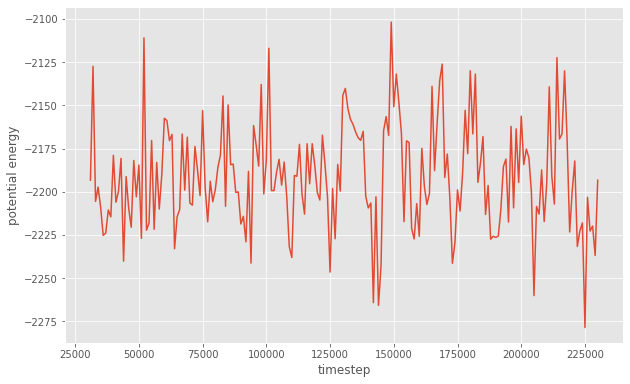

In [14]:
fig = matplotlib.figure.Figure(figsize=(10, 6.18))
ax = fig.add_subplot()
ax.plot(timestep, potential_energy)
ax.set_xlabel('timestep')
ax.set_ylabel('potential energy')
fig

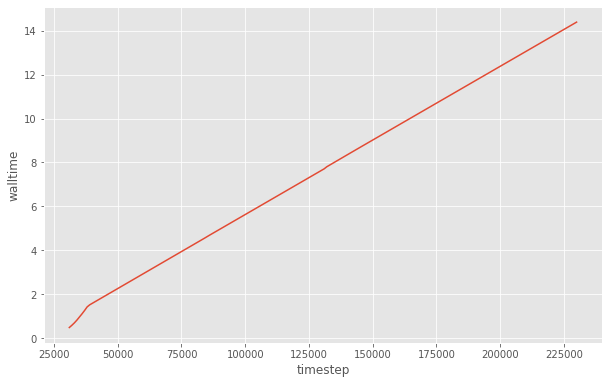

In [15]:
fig = matplotlib.figure.Figure(figsize=(10, 6.18))
ax = fig.add_subplot()
ax.plot(timestep, walltime)
ax.set_xlabel('timestep')
ax.set_ylabel('walltime')
fig

In this section, you have logged quantities to a GSD file during a simulation run and analyzed that data as a time series.
The next section of this tutorial will show you how to save per-particle quantities associated with specific system configurations.

[Previous section](01-Displaying-Status-Information.ipynb) / [Next section](03-Saving-Array-Quantities.ipynb)